==============================================================================================

&lsaquo; GPMIntro.ipynb  &rsaquo;
Copyright (C) &lsaquo; 2017 &rsaquo;  &lsaquo; Anna Scaife - anna.scaife@manchester.ac.uk &rsaquo;

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

==============================================================================================




[AMS - 170402]  Notebook created for SKA-SA Newton Big Data Summer School, Cape Town , April 2017.

This notebook uses GPM to forward predict a signal. It follows the example given in Rasmussen & Williams (http://www.gaussianprocess.org/gpml/chapters/) and optimizes covariance kernel hyper-parameters to predict the CO$_{2}$ concentration on Mauna Loa.  It is a teaching resource and is accompanied by the lecture "Can You Predict the Future..?"

This example uses the george GPM library (http://dan.iel.fm/george/current/user/quickstart/) and the Statsmodel package (http://statsmodels.sourceforge.net/0.6.0/index.html).

Note that the script uses an online dataset and you will need an internet connection for it to run.
--
---------------------------------------------------------------------------------------------

To start let's specify that we want our figures to appear embedded in the notebook:

In [ ]:
%matplotlib inline

Then let's import all the libraries we need...

In [ ]:
import numpy as np
import george
from george import kernels
import statsmodels.api as sm
import scipy.optimize as op
import pylab as pl

First grab the data:

In [ ]:
# For some reason the Mauna Loa dataset seems to have disappeared 
# from the statsmodel package for the moment...

#data = sm.datasets.get_rdataset("co2").data

## time data values:
#t = np.array(data.time)

## CO_2 data values:
#y = np.array(data.co2)

In [4]:
# this is a function to read the Mauna Loa data from file
def read_co2(filename):
    
    co2file = open(filename,'r')
    
    time=[];co2=[]
    while True:
        line = co2file.readline()
        if not line: break
    
        items = line.split()
        
        if (items[0]!='#') and (items[3]!='-99.99'):
            
            time.append(float(items[2]))
            co2.append(float(items[3]))
            
    time=np.array(time)
    co2=np.array(co2)
    
    return time,co2

t,y = read_co2("mauna_loa.dat")

Let's take a look at the data:

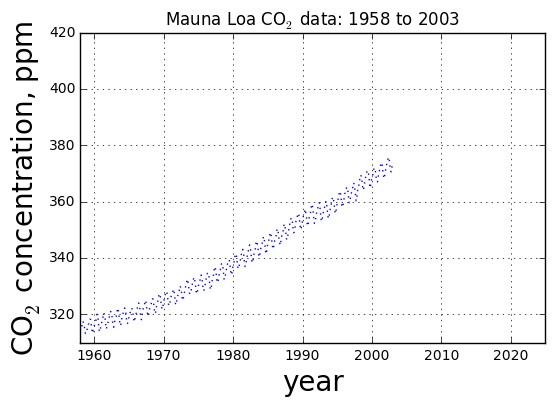

In [5]:
pl.subplot(111)
pl.plot(t[np.where(t<2003.)],y[np.where(t<2003.)],ls=':')
pl.ylabel(r"CO$_2$ concentration, ppm", fontsize=20)
pl.xlabel("year", fontsize=20)
pl.title(r"Mauna Loa CO$_2$ data: 1958 to 2003")
pl.axis([1958.,2025.,310.,420.])
pl.grid()
pl.show()

Let's split out the data up to 2003:

In [6]:
y_to_2003 = y[np.where(t<2003.)]
t_to_2003 = t[np.where(t<2003.)]

Set up the various covariance kernels. These are given by Eq. 5.15 - 5.18 in RW. Note that we've given each of these kernels arguments. These will act as our initial guess at parameter values.

In [7]:
k1 = 66.0**2 * kernels.ExpSquaredKernel(67.0**2)
k2 = 2.4**2 * kernels.ExpSquaredKernel(90**2) * kernels.ExpSine2Kernel(2.0 / 1.3**2, 1.0)
k3 = 0.66**2 * kernels.RationalQuadraticKernel(0.78, 1.2**2)
k4 = 0.18**2 * kernels.ExpSquaredKernel(1.6**2) + kernels.WhiteKernel(0.19)

Then we sum them to make the combined kernel (Eq. 5.19 in RW).

In [8]:
kernel = k1 + k2 + k3 + k4

We then feed this kernel to the george library.

In [9]:
#gp = george.GP(kernel, mean=np.mean(y_to_2005))
gp = george.GP(kernel, mean=0.0)

We can immediately compute the covariance matrix because we've entered some initial guess parameters as the arguments in our kernels.

In [10]:
gp.compute(t_to_2003)

Then we can immediately calculate our prediction out to 2025...

In [11]:
# range of times for prediction:
x = np.linspace(max(t_to_2003), 2025, 2000)

# calculate expectation and variance at each point:
mu, cov = gp.predict(y_to_2003, x)
std = np.sqrt(np.diag(cov))

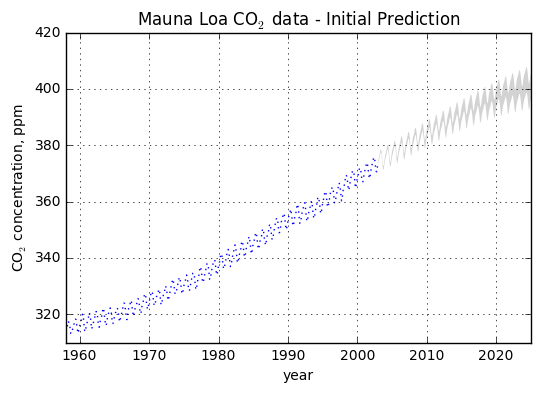

In [12]:
ax = pl.subplot(111)

# plot the original values
pl.plot(t_to_2003,y_to_2003,ls=':') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Initial Prediction")
pl.axis([1958.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

To use the scipy library optimization function we need to provide (1) some function to optimize and (2) the *gradient* of that function. 

Here we define the objective function for the optimization as a negative log-likelihood. We could write this function ourselves, but in fact george has a built in log-likelihood that we can simply call directly.

The log-likelihood is computed as

$$(\mathbf{y} - X^T \mathbf{x})^T C^{-1}(\mathbf{y} - X^T \mathbf{x}) $$

where $y$ is the variable and $x$ are the points at which it is measured; $C$ is the covariance matrix and $X$ is the operator that maps $x$ onto $y$.

In [13]:
# -----------------------------------------------------------------

def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y_to_2003, quiet=True)
    
    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# -----------------------------------------------------------------

And the gradient of the objective function:

In [14]:
# -----------------------------------------------------------------

def grad_nll(p):
    # Update the kernel parameters and compute the likelihood gradient.
    gp.kernel[:] = p
    gll = gp.grad_lnlikelihood(y_to_2003, quiet=True)
    return -gll

# -----------------------------------------------------------------

You need to compute the GP once before starting the optimization. We've actually already done this above, but it doesn't hurt to run it again.

In [15]:
gp.compute(t_to_2003)

Then run the optimization routine:

In [16]:
# initial guess at parameters (see above):
p0 = gp.kernel.vector

# if you want to view your initial guess values uncomment the line below
# print p0

# run optimization:
results = op.minimize(nll, p0, jac=grad_nll)

print np.exp(results.x)

[  1.26302349e+05   1.21437579e+04   6.82453889e+00   9.22329410e+03
   8.71717768e-01   9.99591970e-01   1.14553896e+05   1.33855305e-07
   2.91413731e+04   2.57741420e-01   1.18432106e+00   3.58232439e-02]


Update the kernel with the results of the optimization:

In [17]:
gp.kernel[:] = results.x

Then use this kernel to calculate the predicted expectation value and variance of the data over a range of times:

In [18]:
# range of times for prediction:
x = np.linspace(max(t_to_2003), 2025, 2000)

# calculate expectation and variance at each point:
mu, cov = gp.predict(y_to_2003, x)
std = np.sqrt(np.diag(cov))

Now let's plot the optimised  prediction...

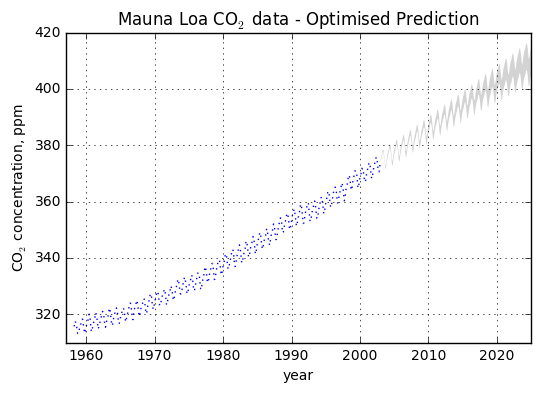

In [19]:
ax = pl.subplot(111)

# plot the original values
pl.plot(t_to_2003,y_to_2003,ls=':') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)
pl.title("Predicted")

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Optimised Prediction")
pl.axis([1957.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

So how did we do? We can compare our prediction to the actual measurements from 2005 until now...

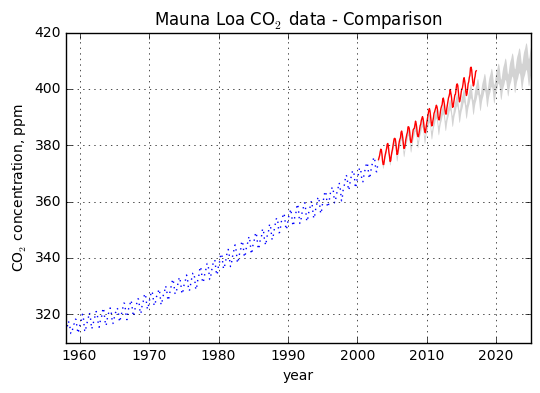

In [20]:
ax = pl.subplot(111)

# plot the training values
pl.plot(t_to_2003,y_to_2003,ls=':',c='b') 

# shade in the area inside a one standard deviation bound:
ax.fill_between(x,mu-std,mu+std,facecolor='lightgrey', lw=0, interpolate=True)

# plot the full dataset
pl.plot(t[np.where(t>2003)],y[np.where(t>2003)],ls='-',c='r') 

pl.ylabel(r"CO$_2$ concentration, ppm")
pl.xlabel("year")
pl.title(r"Mauna Loa CO$_2$ data - Comparison")
pl.axis([1958.,2025.,310.,420.])
pl.grid()

# display the figure:
pl.show()

-- DONE --